In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.8.0


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

In [ ]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

In [ ]:
series[0:10]

array([30.      , 30.087036, 30.168148, 30.243338, 30.312607, 30.375965,
       30.433414, 30.484974, 30.530651, 30.570454], dtype=float32)

In [ ]:
# Update with noise
series += noise(time, noise_level, seed=42)

In [ ]:
series[0:10]

array([32.48357 , 29.395714, 33.40659 , 37.858486, 29.14184 , 29.20528 ,
       38.32948 , 34.322147, 28.183279, 33.283253], dtype=float32)

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
time_train[0:10]

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32)

In [ ]:
x_train[0:10]

array([32.48357 , 29.395714, 33.40659 , 37.858486, 29.14184 , 29.20528 ,
       38.32948 , 34.322147, 28.183279, 33.283253], dtype=float32)

In [ ]:
time_valid[0:10]

array([1000., 1001., 1002., 1003., 1004., 1005., 1006., 1007., 1008.,
       1009.], dtype=float32)

In [ ]:
x_valid[0:10]

array([109.170746, 106.86935 , 102.61668 ,  99.15634 , 105.95478 ,
       104.503876, 107.08533 , 105.858284, 108.00339 , 100.15279 ],
      dtype=float32)

In [ ]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

In [ ]:
forecast[0:10]

[array([[28.56827]], dtype=float32),
 array([[30.921053]], dtype=float32),
 array([[28.321981]], dtype=float32),
 array([[30.186577]], dtype=float32),
 array([[28.723652]], dtype=float32),
 array([[30.93653]], dtype=float32),
 array([[27.960274]], dtype=float32),
 array([[25.99095]], dtype=float32),
 array([[28.498917]], dtype=float32),
 array([[27.868782]], dtype=float32)]

In [ ]:
forecast = forecast[split_time-window_size:]

In [ ]:
forecast[0:10]

[array([[104.14723]], dtype=float32),
 array([[106.37421]], dtype=float32),
 array([[104.96083]], dtype=float32),
 array([[104.01006]], dtype=float32),
 array([[105.51776]], dtype=float32),
 array([[104.405334]], dtype=float32),
 array([[101.503525]], dtype=float32),
 array([[103.73786]], dtype=float32),
 array([[104.904854]], dtype=float32),
 array([[106.23689]], dtype=float32)]

In [ ]:
results = np.array(forecast)[:, 0, 0]

In [ ]:
results[0:10]

array([104.14723 , 106.37421 , 104.96083 , 104.01006 , 105.51776 ,
       104.405334, 101.503525, 103.73786 , 104.904854, 106.23689 ],
      dtype=float32)

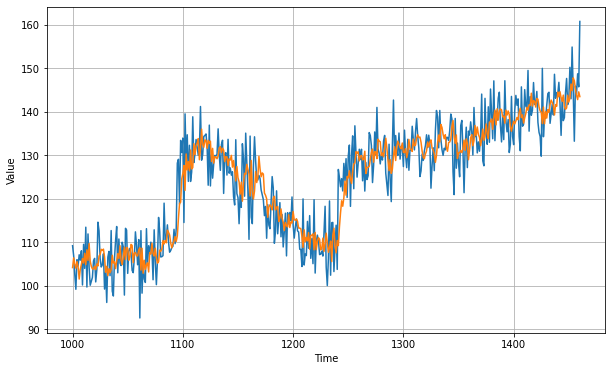

In [ ]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.601424

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

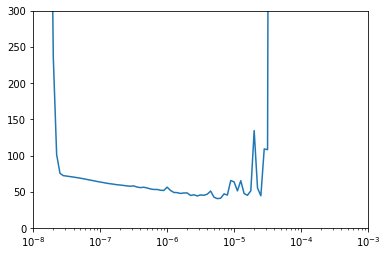

In [ ]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [ ]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

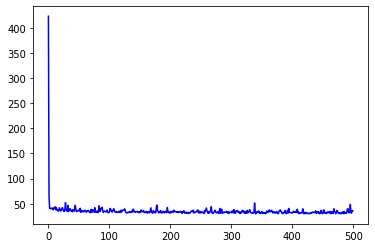

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[42.00128936767578, 44.028751373291016, 38.274200439453125, 42.67937469482422, 37.333580017089844, 38.22188186645508, 35.50942611694336, 35.725791931152344, 42.117332458496094, 39.14776611328125, 35.803314208984375, 36.830318450927734, 40.181148529052734, 42.410728454589844, 38.61817932128906, 35.09512710571289, 34.74352264404297, 39.20521545410156, 52.435386657714844, 37.458702087402344, 35.85172653198242, 34.964900970458984, 46.85862731933594, 34.4453010559082, 39.57695007324219, 37.84418487548828, 40.01338577270508, 36.36147689819336, 36.02306365966797, 33.82282257080078, 38.489463806152344, 36.77255630493164, 35.113380432128906, 38.27722930908203, 47.009700775146484, 38.53670120239258, 34.552215576171875, 35.20927429199219, 35.20102310180664, 37.27842712402344, 36.768367767333984, 35.70700454711914, 41.10402297973633, 33.19422912597656, 36.91706085205078, 33.92870330810547, 36.180824279785156, 34.984622955322266, 33.913082122802734, 36.78571319580078, 36.76244354248047, 36.30157852

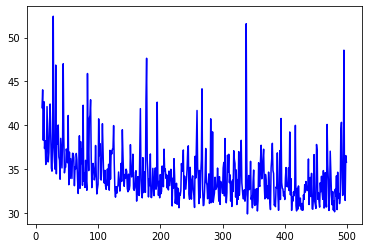

In [ ]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

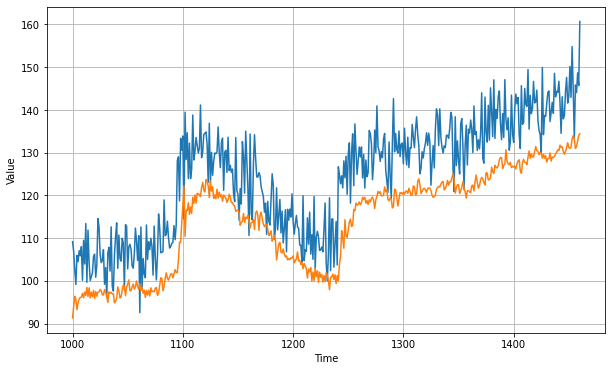

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

10.295904